 # Hyperparameter Search for MPF Bagged Model



 In this cell we define helper functions for evaluating one hyperparameter candidate and performing a randomized search in parallel. We then use our random search function on training data.

In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import mpf_py
from utils import gen_data, true_model3, plot_2d_model_predictions  # Adjust import according to your project structure
from scipy.stats import randint

def evaluate_params(x_train, y_train, kf, **params):
    """
    Evaluates one hyperparameter combination using cross-validation.
    Returns a tuple (epochs, B, n_iter, split_try, avg_mse).
    """
    errors = []
    for train_index, val_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_val = x_train[val_index]
        y_val = y_train[val_index]

        # Fit the bagged model on the training split.
        print(params)
        model, fr = mpf_py.MPF.fit_bagged(
            x_tr, y_tr, **params
        )
        # Predict on the validation split.
        y_pred = model.predict(x_val)
        mse = np.mean((y_val - y_pred) ** 2)
        errors.append(mse)
    avg_error = np.mean(errors)
    return avg_error

def random_hyperparam_search_parallel(x_train, y_train, n_splits=2, n_candidates=50, n_jobs=-1, param_distributions=None):
    """
    Performs a random grid search cross-validation over hyperparameters for mpf_py.MPF.fit_bagged.
    
    Parameters:
        x_train, y_train: Training data.
        n_splits: Number of cross-validation splits.
        n_candidates: Number of hyperparameter combinations to evaluate.
        n_jobs: Number of parallel jobs.
        param_distributions: A dictionary specifying the hyperparameter distributions.
                           Each key is a hyperparameter name, and each value is a distribution
                           (e.g., scipy.stats.randint, scipy.stats.uniform).
    
    Returns the best model, additional fitted result (fr), best parameters, and best error.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Default parameter distributions if none are provided.
    if param_distributions is None:
        param_distributions = {
            "epochs": lambda: randint(2, 9).rvs(),       # 1 to 8 inclusive
            "n_iter": lambda: randint(5, 101).rvs(),         # 5 to 100 inclusive
            "split_try": lambda: randint(5, 21).rvs(),         # 5 to 20 inclusive
            "B": lambda: randint(10, 101).rvs(),         # 10 to 100 inclusive
            "colsample_bytree": lambda: 1.0,
            "identified": lambda: True
        }
    
    # Generate n_candidates random hyperparameter combinations.
    param_list = []
    for _ in range(n_candidates):
        params = {
            name: dist() for name, dist in param_distributions.items()
        }
        param_list.append(params)
        
    # Evaluate candidates in parallel.
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(evaluate_params)(x_train, y_train, kf, **params)
        for params in param_list
    )
    
    best_params = None
    best_error = np.inf
    for (avg_error, params) in zip(results, param_list):
        print(f"Params: {params} --> MSE={avg_error:.4f}")
        if avg_error < best_error:
            best_error = avg_error
            best_params = params
    
    # Refit the model on the full training set with the best hyperparameters.
    best_model, best_fr = mpf_py.MPF.fit_bagged(
        x_train, y_train,
        **best_params
    )
    
    return best_model, best_fr, best_params, best_error


 ### Example Usage for MPF



 Here we generate training data (using a hypothetical `gen_data` and `true_model3` from your utils) and run the random hyperparameter search.

In [4]:
# Generate data
true_model = lambda x: 2*x[:,1] + x[:,0] - 0.5 * x[:,0]* x[:,1] + 34

x, y = gen_data(n=10000, seed=3, model=true_model3)
x_train = x[:5000]
y_train = y[:5000]

x_test = x[5000:]
y_test = y[5000:]


In [11]:
# Fit the best MPF model
best_model, best_fr, best_params, best_error = random_hyperparam_search_parallel(
    x_train, y_train, n_splits=2, n_candidates=50, n_jobs=3, param_distributions= {
        "epochs": lambda: randint(2, 9).rvs(),       # 1 to 8 inclusive
        "n_iter": lambda: randint(5, 101).rvs(),         # 5 to 100 inclusive
        "split_try": lambda: randint(5, 21).rvs(),         # 5 to 20 inclusive
        "B": lambda: randint(10, 101).rvs(),         # 10 to 100 inclusive
        "colsample_bytree": lambda: 1.0,
        "identified": lambda: False
    })
print("Best hyperparameters for MPF:", best_params)
print("Best CV MSE for MPF:", best_error)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


{'epochs': 8, 'n_iter': 49, 'split_try': 18, 'B': 68, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 3, 'n_iter': 37, 'split_try': 14, 'B': 82, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 5, 'n_iter': 63, 'split_try': 7, 'B': 39, 'colsample_bytree': 1.0, 'identified': False}{'epochs': 2, 'n_iter': 97, 'split_try': 16, 'B': 28, 'colsample_bytree': 1.0, 'identified': False}

{'epochs': 2, 'n_iter': 80, 'split_try': 15, 'B': 69, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 4, 'n_iter': 23, 'split_try': 8, 'B': 62, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 6, 'n_iter': 10, 'split_try': 19, 'B': 20, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 5, 'n_iter': 55, 'split_try': 9, 'B': 84, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 4, 'n_iter': 35, 'split_try': 6, 'B': 53, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 7, 'n_iter': 51, 'split_try': 6, 'B': 66, 'colsample_bytree': 1.0, 'identified': False}
err: 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.5s


err: 0.19321490569401928
err: 0.4446219692449211
err: 0.17252273513558156
err: 0.18708686826199475
err: 0.20673723138976366
err: 0.16996614162299967
err: 0.23129996627622026
err: 0.4145358753887327
err: 0.4306076698247816
err: 0.1882135047693123
err: 0.23309793543486745
err: 0.19521061627292394
err: 0.22451268609147623
err: 0.1713248006581023
err: 0.19570000235177062
err: 0.18733661541437854
err: 0.16443280465073007
err: 0.18867425759414336
{'epochs': 2, 'n_iter': 61, 'split_try': 11, 'B': 10, 'colsample_bytree': 1.0, 'identified': False}
err: 0.18208349930642556
err: 0.49673189228333875
err: 0.5199390062084777
err: 0.22858744606524686
err: 0.4336155117828576
err: 0.4457388630638587
err: 0.19446258178624223
err: 0.4956938781019968
err: 0.484759783052894
err: 0.19121897602716015
err: 0.18834373733264329
err: 0.22823178819894643
err: 0.43945115716280314
err: 0.17922739112959574
err: 0.17887775657974236
err: 0.16859115918845222
err: 0.42835685608607244
err: 0.4372064386114414
err: 0.17817

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   45.7s


err: 0.2127085478835082
err: 0.1895878804166054
err: 0.2094279118728134
err: 0.5238845613950326
err: 0.20979822703956566
err: 0.17532688018281203
err: 0.5392972184816714
err: 0.5606385198073933
err: 0.5616832368879662
err: 0.5137771325609599
err: 0.5454843927630887
err: 0.5339012299088661
err: 0.17901640603777663
err: 0.19016776328877816
err: 0.20065585700877545
err: 0.20424151919896766
err: 0.16805324594966234
err: 0.543270370297764
err: 0.1947976930657021
err: 0.1969249477671002
err: 0.4797331757479055
err: 0.511533957466
err: 0.19116052289128949
err: 0.1905098601693303
err: 0.5359247628883748
err: 0.5440301659952981
err: 0.18583538739900993
err: 0.20088190987331794
err: 0.21573513183487103
err: 0.1932301781078778
err: 0.5756790945960082
err: 0.1944123967158318
err: 0.19253779055005324
err: 0.19434074868102158
err: 0.20681979105303708
err: 0.2181037512762972
err: 0.5306286868446667
err: 0.5703465249386509
err: 0.5042685177916052
err: 0.49907690342897615
err: 0.5401763585420329
err: 0

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min


err: 0.17031045531737687
err: 0.2198793038689194
err: 0.1734863009671921
err: 0.2134506919340804
err: 0.20904974610499322
err: 0.17759029278357516
err: 0.20393899654187295
err: 0.4459991441984964
err: 0.2093096667388192
err: 0.21936490264430172
err: 0.22526160647329788
err: 0.20767769800134853
err: 0.2113144046425845
err: 0.1765901280382701
err: 0.14250542527052443
err: 0.21443579937731833
err: 0.17934122735963612
err: 0.2076639046469287
err: 0.4331098961295965
err: 0.22771985046349436
err: 0.16304994229430175
err: 0.21814447358352937
err: 0.17650405048461051
err: 0.18398231293702982
err: 0.14289696171483196
err: 0.2216039418092676
err: 0.23914436107556225
err: 0.46185632865439774
err: 0.24004533504432501
err: 0.16871827629494907
err: 0.2128203356029614
err: 0.1432646656795885
err: 0.2180123633004043
err: 0.4621645097376941
err: 0.21894429050442554
err: 0.16654027461994578
err: 0.47241390645948106
err: 0.16282098462473235
err: 0.17586079177724606
err: 0.16316081034274002
err: 0.1721291

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.8min


err: 0.21473372357989579
err: 0.1658074316471265
err: 0.1699569812267315
err: 0.4437636535099288
err: 0.47017419499373764
err: 0.1861960099797211
err: 0.2019437122601088
err: 0.15495388001939941
err: 0.21150879094806765
err: 0.4430646946299933
err: 0.1554691061536234
err: 0.6080379543177719
err: 0.1293286820974095
err: 0.5544653894369718
err: 0.48374145901331655
err: 0.12254320866335806
err: 0.6023596299928269
err: 0.454290756797772
err: 0.5804539146258808
err: 0.17496938042901006
err: 0.21051116926727095
err: 0.5962362127020964
err: 0.19980072119484565
err: 0.6034869613592428
err: 0.4451494118843701
err: 0.15637677560885052
err: 0.15744187659160103
err: 0.16078533529447725
err: 0.1676002474193416
err: 0.15844097765546963
err: 0.1599948829785866
err: 0.16340442336045335
err: 0.4438947459392976
err: 0.6231189795014475
err: 0.19987330881037824
err: 0.45306437271936173
err: 0.6626768490318838
err: 0.16196508881595367
err: 0.4439473393627053
err: 0.5618502452465434
err: 0.12357762344474113

[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  2.1min remaining:   44.5s


err: 0.8119530950546772
err: 0.6921025069080533
err: 0.7572006884880241
err: 0.671871398214735
err: 0.19030615456429173
err: 0.6949863658599078
err: 0.4642314410823562
err: 0.7696199256284267
err: 0.12967065965444832
err: 0.7128638124151684
err: 0.8019206428107304
err: 0.6970762417529893
err: 0.2591023127964479
err: 0.664098045275751
err: 0.19498295494978662
err: 0.1918712007174098
err: 0.6537260150015036
err: 0.6411721326114898
err: 0.6441719392160732
err: 0.25919215053344896
err: 0.18812758857462342
err: 0.6666214807036298
err: 0.1904005806965463
err: 0.24917337017021604
err: 0.4805299101458498
err: 0.7166654844089275
{'epochs': 7, 'n_iter': 84, 'split_try': 16, 'B': 62, 'colsample_bytree': 1.0, 'identified': False}
err: 0.722112440058324
err: 0.19785699570567852
err: 0.2046025502011142
err: 0.48243292117520525
err: 0.1918307298606345
err: 0.6530247592657549
err: 0.6651540823938756
err: 0.27094775511631775
err: 0.19049708516483918
err: 0.19925122312236482
err: 0.46360556004003045
err

[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  2.3min remaining:   22.0s


err: 0.42574321578429
err: 0.4328211101740024
err: 0.1871366090279525
err: 0.23052840573893804
err: 0.1758266423118489
err: 0.182773848451245
err: 0.24147211710170727
err: 0.24808343660159982
err: 0.21293966876606624
err: 0.2251053269960221
err: 0.2463487598352766
err: 0.17212691771070873
err: 0.1763831661951471
err: 0.43548534698932334
err: 0.25386984300595045
err: 0.17901986128111713
err: 0.23955539883808283
err: 0.2260007015529105
err: 0.19424909035323806
err: 0.1896259472813211
err: 0.22303468051675696
err: 0.1830032271545877
err: 0.23724965509998824
err: 0.22052599738420653
err: 0.2197761062556939
err: 0.22988657669180393
err: 0.21649186433731835
err: 0.1950580491298318
err: 0.1973028113885334
err: 0.21609872073805805
err: 0.18299401603998502
err: 0.24690093998814627
err: 0.43798463665869825
err: 0.4195361852018041
err: 0.23718990226093598
err: 0.2456320256097978
err: 0.19803356761181937
err: 0.19892804555851495
err: 0.43207991470287727
err: 0.177263448078441
err: 0.19345688827895

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


Best hyperparameters for MPF:err: 0.5329956413950702
err: 0.5158618607888209
err: 0.5250408729707076
err: 0.541453539766372
err: 0.5474073040061905
err: 0.5200491232714751
err: 0.521786730993357
err: 0.5247651654845461
err: 0.5292361036439331
err: 0.5221996755674323
err: 0.5192203153041653
err: 0.5332061283692702
err: 0.5215473596163646
err: 0.5310689913065914
err: 0.5204708960308472
err: 0.5343115048771806
err: 0.5179637178570925
err: 0.5386499939184772
err: 0.5316318440306893
err: 0.5218565742635204
err: 0.5245873555407018
err: 0.5201054990104685
err: 0.6074250895025446
err: 0.5411196339285821
err: 0.5233583102639661
err: 0.5229863119419919
err: 0.5110428529730214
err: 0.5209820059824626
err: 0.5283679480847661
err: 0.5237652821580357
err: 0.5061647209829234
err: 0.5322365169564613
err: 0.5350332953390294
err: 0.5275575451504141
err: 0.5072217296386013
err: 0.5206596653538402
err: 0.5225322794232008
err: 0.5283284278546653
err: 0.5373590022876662
err: 0.5271676325588993
err: 0.515565

In [12]:
best_params, best_error


({'epochs': 6,
  'n_iter': 29,
  'split_try': 7,
  'B': 60,
  'colsample_bytree': 1.0,
  'identified': False},
 np.float64(0.26493458136386433))

 # Hyperparameter Search for XGBoost



 In this section we use scikit‑learn’s RandomizedSearchCV with continuous and discrete ranges. We fix 2‑fold (or 4‑fold as set below) cross‑validation and use random sampling over the following ranges:



 - `max_depth`: integers from 3 to 9,

 - `learning_rate`: continuous values in [0.001, 0.6],

 - `n_estimators`: integers from 200 to 800.



 We then print the best hyperparameters and CV MSE, and retrieve the best model.

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameter distributions.
param_distributions = {
    'max_depth': randint(3, 10),           # Integers from 3 to 9.
    'learning_rate': uniform(0.001, 0.599),  # Continuous values in [0.001, 0.6].
    'n_estimators': randint(200, 801)        # Integers from 200 to 800.
}

# Create an XGBRegressor.
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV with 4-fold CV.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=1000,   # number of random candidates to try
    scoring='neg_mean_squared_error',
    cv=4,         # use 4-fold cross-validation (adjust as needed)
    n_jobs=-1,    # use all available cores
    verbose=1,
    random_state=42
)

# Run the randomized hyperparameter search.
random_search.fit(x_train, y_train)
print("Best xgboost hyperparameters:", random_search.best_params_)
print("Best xgboost CV MSE:", -random_search.best_score_)

best_model_xgboost = random_search.best_estimator_


Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Best xgboost hyperparameters: {'learning_rate': np.float64(0.028823797219278635), 'max_depth': 5, 'n_estimators': 220}
Best xgboost CV MSE: 0.26044343396645886


 # Comparing Models



 Finally, we plot the true model, the best MPF model, and the best XGBoost model using a provided plotting function `plot_model_predictions`.

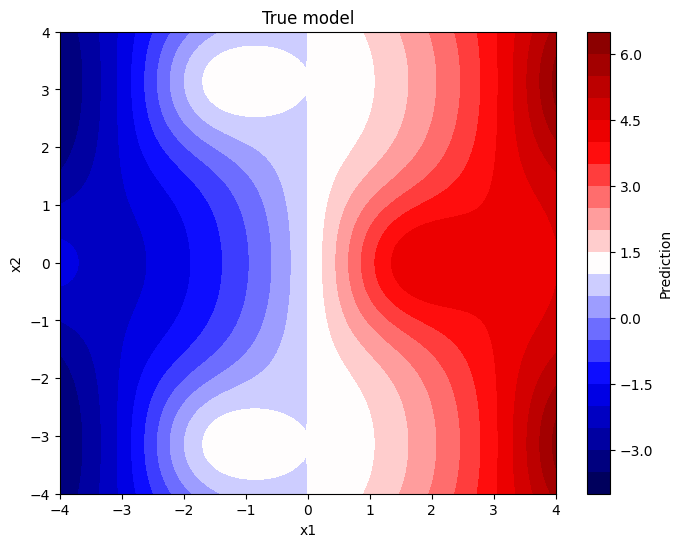

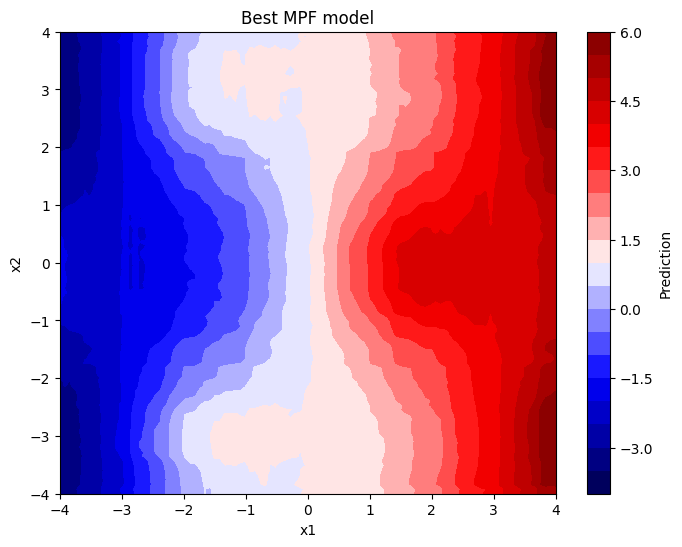

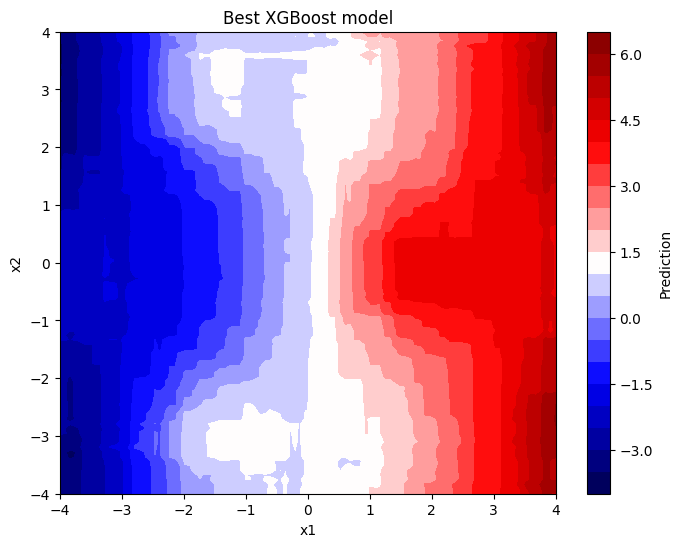

In [15]:
# Assuming plot_model_predictions is defined in your environment
plot_2d_model_predictions(true_model3, title="True model")
plot_2d_model_predictions(lambda x: best_model.predict(x), title="Best MPF model")
plot_2d_model_predictions(lambda x: best_model_xgboost.predict(x), title="Best XGBoost model")


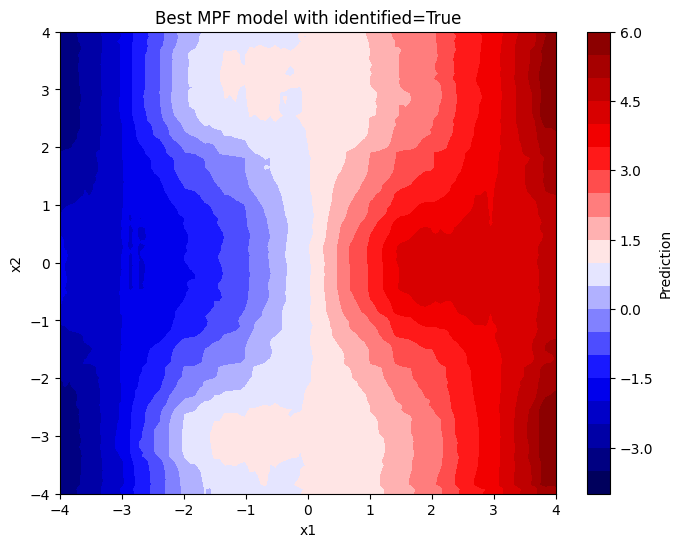

Test MSE for MPF with identified=True: 0.26356030130158015


In [17]:
# Plot the best MPF model with identified=True
plot_2d_model_predictions(lambda x: best_model.predict(x), title="Best MPF model with identified=True")
test_preds = best_model.predict(x_test)
test_error = np.mean((y_test - test_preds) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error}")


Combining tree grids into a single tree grid.
Combining tree grids into a single tree grid.
Combining tree grids into a single tree grid.


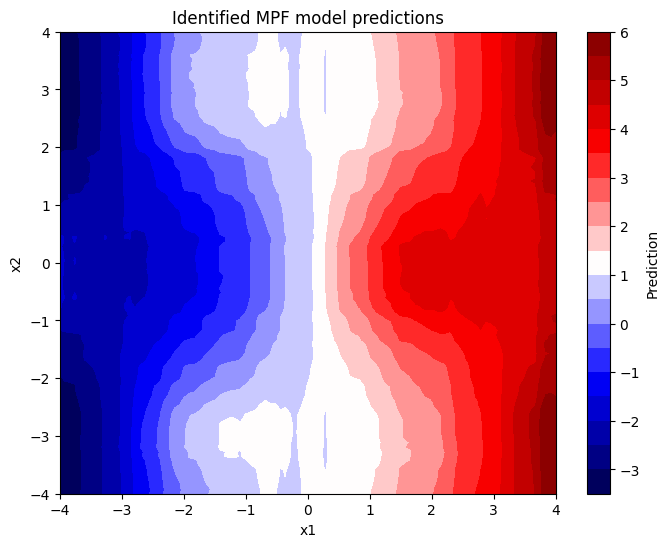

Test MSE for MPF with identified=True: 0.2676140661260334


In [18]:
mpf_tree_grid_rep = [mpf_py.TreeGrid(tgf.combined_tree_grid) for tgf in best_model_identified.tree_grid_families]

pred_function = lambda x: sum([tg.predict(x) for tg in mpf_tree_grid_rep])

plot_2d_model_predictions(pred_function, title="Identified MPF model predictions")
test_preds_identified = pred_function(x_test)
test_error_identified = np.mean((y_test - test_preds_identified) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error_identified}")


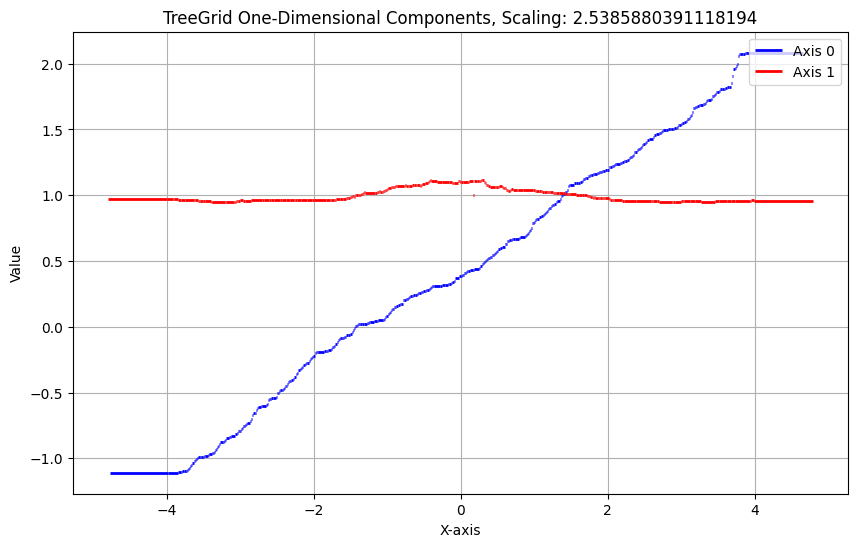

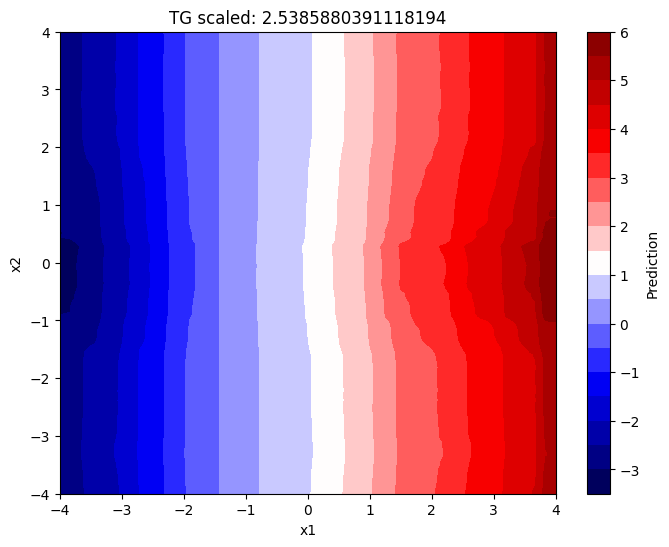

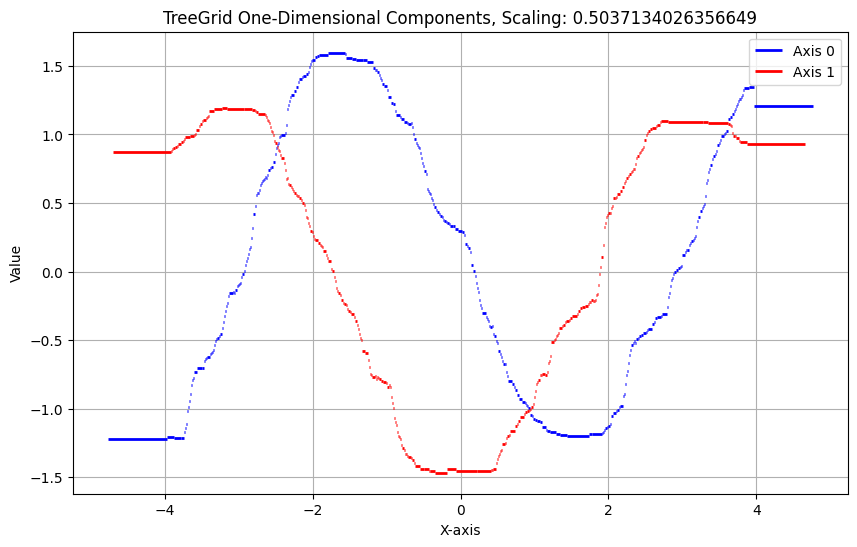

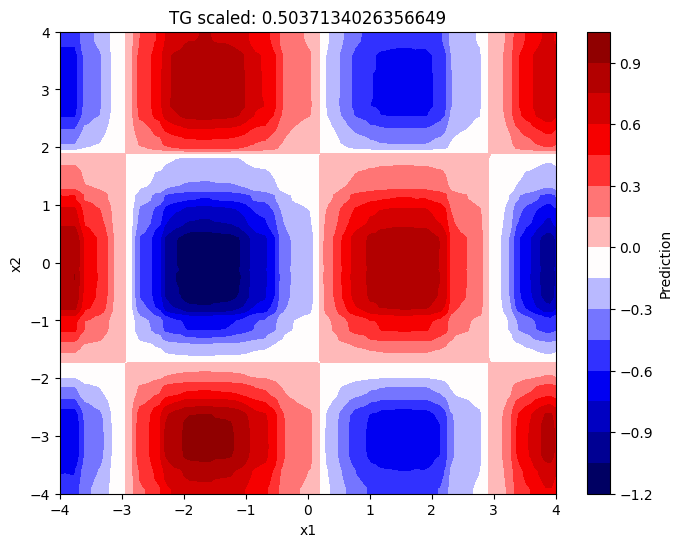

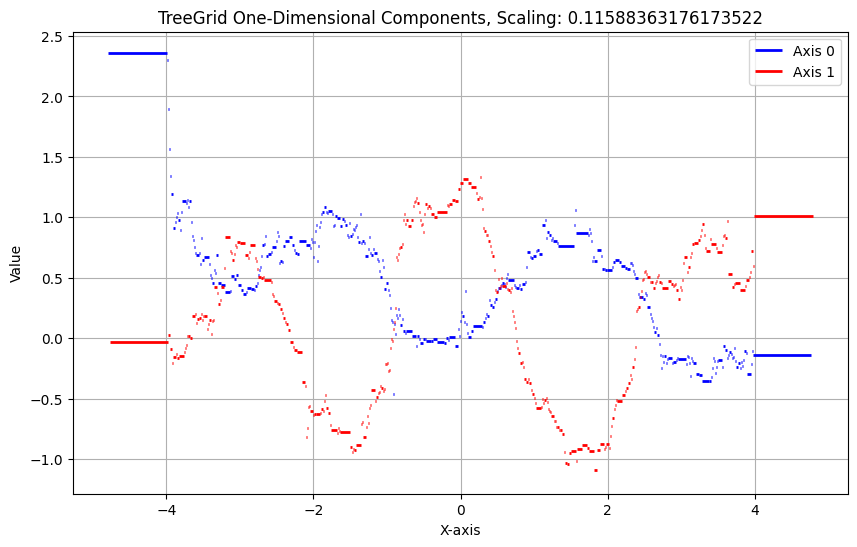

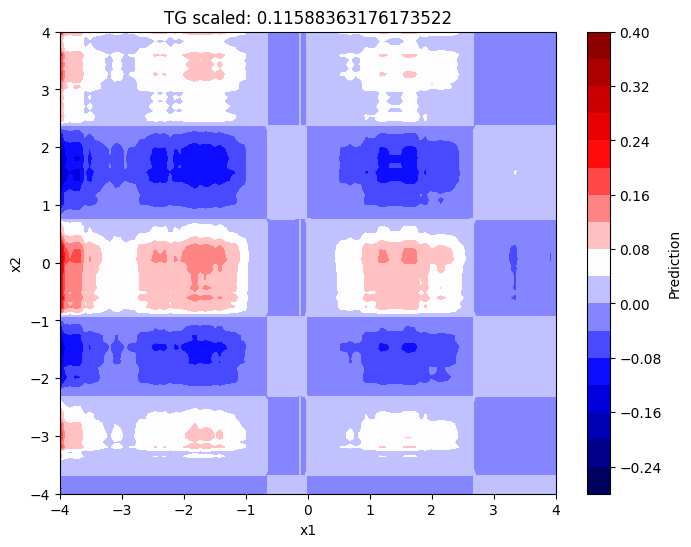

In [19]:
for tg in mpf_tree_grid_rep:
    tg.plot_components()
    plot_2d_model_predictions(lambda x: tg.predict(x), title=f"TG scaled: {tg.scaling}")
